# Initial learning trials
functional: b3lypg

basis: sto-3g

In [19]:
import numpy as np
from glob import glob
import os, sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge


train_test_seed = 42

source_path = '../../datasets/QM9/xyz_c5h4n2o2/'
all_file_paths = glob(os.path.join(source_path, '*.xyz'))
len(all_file_paths)

509

In [20]:
scripts_path = "../../scripts"
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
from to_cache import density_fock_overlap

check if all files converged - if we have something to compare to!

In [21]:
focks = []
used_files = []
reference_densities = []
for file in all_file_paths:
    mol_name = os.path.basename(file).split(".")[0]
    # print(mol_name)
    ret = density_fock_overlap(filepath = file,
                         filename = mol_name,
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = "../../datasets/QM9/out/c5h4n2o2-sto-3g-b3lyp")
    if any([r == None for r in ret]): 
        print(f"File {mol_name} bad - skipping")
        continue
    focks.append(ret[1].numpy)
    used_files.append(file)
    reference_densities.append(ret[0].numpy)
print(f"Using {len(focks)} files from {len(all_file_paths)} total files")

File dsgdb9nsd_057125 bad - skipping
Using 508 files from 509 total files


Now let's create the reference - use the overlap matrix - this is already needed for the first step so this is basically free! 

In [22]:
from scf_guess_tools import Backend, load
from pyscf.gto import Mole
import re, time
import matplotlib.pyplot as plt

overlaps = []
for file in used_files:
    lines = open(file).readlines()
    q = int(re.search(r"charge\s+(-?\d+)", lines[1]).group(1))
    m = int(re.search(r"multiplicity\s+(\d+)", lines[1]).group(1))
    start_ = time.time()
    mol = Mole(atom=file, charge=q, spin=m - 1, symmetry=True)
    mol.basis = 'sto-3g'
    mol.build()
    S = mol.intor('int1e_ovlp')
    overlaps.append(np.asarray(S))

Now we have our in & outputs but half of the matrix is irrelevant so we use the following utility functions

In [23]:
def flatten_triang(M): 
    return M[np.triu_indices(M.shape[0], k=0)]
def unflatten_triang(flat, N):
    M = np.zeros((N, N))
    iu = np.triu_indices(N)
    M[iu] = flat
    M[(iu[1], iu[0])] = flat  # Symmetrie
    return M

## Dataset split

In [24]:
import pickle

train, test = train_test_split(
    list(zip(focks, overlaps, used_files, reference_densities)), 
    test_size=0.2, 
    random_state=train_test_seed
)
with open("models/test_data.pkl", "wb") as f:
    pickle.dump(test, f)
with open("models/train_data.pkl", "wb") as f:
    pickle.dump(train, f)

### Now Ridge Regression

In [25]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.linear_model import RidgeCV
from sklearn.multioutput import MultiOutputRegressor
import pickle
model_path = "models/simple_ridge_model.mpkl"

In [26]:
X_unscaled = np.array([flatten_triang(overlap) for _, overlap, _, _ in train])
y_unscaled = np.array([flatten_triang(fock) for fock, _ , _, _ in train])
X_test_unscaled = np.array([flatten_triang(overlap) for _ , overlap, _, _ in test])
y_test_unscaled = np.array([flatten_triang(fock) for fock, _, _, _  in test])
def summary(X, name):
    print(f"Summary {name}:")
    print(f"Shape: {X.shape}")
    print(f"Mean: {np.mean(X)}")
    print(f"Std Dev: {np.std(X)}")
    print(f"Min: {np.min(X)}")
    print(f"Max: {np.max(X)}")

summary(X_unscaled, "X")
summary(y_unscaled, "y")

print("---")
summary(X_test_unscaled, "X_test")
summary(y_test_unscaled, "y_test")
# scale input data 
# X = scaler.fit_transform(X)
# X_test = scaler.transform(X_test)

Summary X:
Shape: (406, 1225)
Mean: 0.04801266638789597
Std Dev: 0.21050674256765434
Min: -0.4781431157238504
Max: 1.0000000000000002
Summary y:
Shape: (406, 1225)
Mean: -0.15972745575851086
Std Dev: 1.2019458977162485
Min: -19.082993158006012
Max: 1.3785386560655133
---
Summary X_test:
Shape: (102, 1225)
Mean: 0.048151648810501026
Std Dev: 0.2104438017872892
Min: -0.47816030729607034
Max: 1.0000000000000002
Summary y_test:
Shape: (102, 1225)
Mean: -0.15975009783455124
Std Dev: 1.2020245260100753
Min: -19.082119783382346
Max: 1.369968133986999


Am besten skalieren wir jetzt beides! 

In [27]:
# scaler_X = StandardScaler(with_mean=False)
# scaler_y = StandardScaler(with_mean=False)
scaler_X = MaxAbsScaler()
scaler_y = MaxAbsScaler()

X = scaler_X.fit_transform(X_unscaled)
X_test = scaler_X.transform(X_test_unscaled)
y = scaler_y.fit_transform(y_unscaled)
y_test = scaler_y.transform(y_test_unscaled)
summary(X, "X")
summary(y, "y")
print("---")
summary(X_test, "X_test")
summary(y_test, "y_test")



Summary X:
Shape: (406, 1225)
Mean: 0.07496593997932931
Std Dev: 0.3303183733347925
Min: -1.0
Max: 1.0
Summary y:
Shape: (406, 1225)
Mean: -0.057002999958299716
Std Dev: 0.30320834293028937
Min: -1.0
Max: 1.0
---
Summary X_test:
Shape: (102, 1225)
Mean: 0.07570677407534641
Std Dev: 0.3319735969724697
Min: -2.904640581200957
Max: 9.801095090864921
Summary y_test:
Shape: (102, 1225)
Mean: -0.05746639871568178
Std Dev: 0.30513181069059536
Min: -9.7528890769687
Max: 2.8589574065087993


Skalieren macht es aktiv schlechter also trainieren wir auf den unskalierten

In [28]:
X = X_unscaled
y = y_unscaled
X_test = X_test_unscaled
y_test = y_test_unscaled

In [29]:
if os.path.exists(model_path):
    print("Loading model from disk...")
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
else:
    # Train the model
    print("Training model...")
    # Flatten the matrices and train the model
    base_model = RidgeCV(alphas=np.logspace(0, 3, 5, base=10), cv=5)
    # base_model = RidgeCV(alphas=[100,1000], cv=5)
    model = MultiOutputRegressor(base_model)
    start_ = time.time()
    model.fit(X,y=y)
    print(f"CV Training time: {time.time() - start_:.2f} seconds")
    best_alphas = np.array([estimator.alpha_ for estimator in model.estimators_])
    print(f"Best alphas: \nmean: {best_alphas.mean()}\nstd: {best_alphas.std()}\nmin: {best_alphas.min()}\nmax: {best_alphas.max()}")
    base_model = Ridge(alpha=best_alphas.mean())
    model = MultiOutputRegressor(base_model)

    start_ = time.time()
    model.fit(X, y=y)
    print(f"Refit-Training time: {time.time() - start_:.2f} seconds")
    
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)


train_pred = model.predict(X)
train_error = root_mean_squared_error(y, train_pred)
print(f"Train error: {train_error:.4f}")

# test error:
test_pred = model.predict(X_test)
test_error = root_mean_squared_error(y_test, test_pred)
print(f"Test error: {test_error:.4f}")
sum_of_squares = np.mean(np.sum((np.zeros_like(y_test) - y_test)**2, axis=1))
print(f"Average sum of squares of y_test: {sum_of_squares:.4f}")

Loading model from disk...
Train error: 0.0465
Test error: 0.0593
Average sum of squares of y_test: 1801.2192


In [30]:
from scipy.linalg import eigh
def check_positive_definite(S, tol=1e-10):
    # Eigenwerte prüfen
    eigvals = np.linalg.eigvalsh(S)
    is_pd = np.all(eigvals > tol)
    return is_pd

def density_pred(model, overlap, nocc): 
    assert check_positive_definite(overlap)
    fock = model.predict(flatten_triang(overlap).reshape(1, -1))
    fock = unflatten_triang(fock, overlap.shape[0])
    _, C = eigh(fock, overlap)
    C_occ = C[:, :nocc]
    density = 2 * C_occ @ C_occ.T # *2 because of spin degeneracy
    return density

def comp_trace(overlap, *args): 
    for arg in args: 
        trace_ = np.trace(arg @ overlap)
        print(f"Trace: {trace_}")
    

Get f-scores for densities

In [13]:
from scf_guess_tools import build, f_score, Backend, calculate, guess
backend = Backend.PY
def get_mean_fscore(data_set):
    f_scores = []
    for fock, overlap, used_file, ref_density in data_set: 
        
        pred_density = density_pred(model, overlap, 32)
        pred_density = build(pred_density, backend)
        ref_density = build(ref_density, backend)
        overlap = build(overlap, backend)
        
        fs = f_score(overlap, ref_density, pred_density) 
        f_scores.append(fs)
    mean_fs = np.mean(f_scores)
    std_fs = np.std(f_scores)
    print(f"Mean F-score: {mean_fs:.4f} +- {std_fs:.4f}")

get_mean_fscore(train)
get_mean_fscore(test)

KeyboardInterrupt: 

F-score of 1e guess on Testset

In [15]:
def get_mean_fscore_guess(data_set, scheme):
    f_scores = []
    for fock, overlap, used_file, ref_density in data_set: 
        mol = load(used_file, backend)
        wf = guess(mol, basis="sto-3g", method="dft", functional="b3lypg", scheme=scheme, cache=False)

        f_scores.append(f_score(wf.overlap(), wf.density(), build(ref_density, backend)))
        
    mean_fs = np.mean(f_scores)
    std_fs = np.std(f_scores)
    print(f"Mean F-score: {mean_fs:.4f} +- {std_fs:.4f}")
get_mean_fscore_guess(test, "minao")
get_mean_fscore_guess(test, "1e")
get_mean_fscore_guess(test, "atom")
get_mean_fscore_guess(test, "huckel")
get_mean_fscore_guess(test, "vsap")

Mean F-score: 0.8992 +- 0.0021
Mean F-score: 0.7059 +- 0.0156
Mean F-score: 0.8920 +- 0.0021
Mean F-score: 0.8401 +- 0.0099
Mean F-score: 0.9932 +- 0.0020


VSAP is insane on this dataset let's try a calc

In [16]:
mol = load(used_files[0], backend)
guess_wf = guess(mol, basis="sto-3g", method="dft", functional="b3lypg", scheme="vsap", cache=False)
guess_f_score = f_score(guess_wf.overlap(), guess_wf.density(), build(reference_densities[0], backend))
print(f"F-score guess: {guess_f_score:.4f}")
wf = calculate(mol, basis="sto-3g", method="dft", functional="b3lypg", guess=guess_wf, cache=False)
wf.native.cycles

F-score guess: 0.9899
converged SCF energy = -446.850250909027


13

ok sum of squares is really large compared to RMSE and RMSE between train and test is comparable but certainly not good -> I mean we have a small dataset only 508 samples!

In [14]:
def plot_fock_comparison(ex_test, ex_pred, size, matrix_metric="Fock", title="Fock Matrix Comparison", vmax=1.5):
    diff = ex_test - ex_pred
    rmse = root_mean_squared_error(ex_test, ex_pred)
    
    test_mat = unflatten_triang(ex_test, size) if ex_test.shape[0] != size else ex_test
    pred_mat = unflatten_triang(ex_pred, size) if ex_pred.shape[0] != size else ex_pred
    diff_mat = unflatten_triang(diff, size) if diff.shape[0] != size else diff
    
    fig, ax = plt.subplots(1, 4, figsize=(15, 5), width_ratios=[1, 1, 1, 0.1])
    fig.suptitle(f"{title}  |  RMSE: {rmse:.8f}")
    
    ax[0].imshow(test_mat, cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax[0].set_title(f"{matrix_metric} converged (REFERENCE)")
    
    ax[1].imshow(pred_mat, cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax[1].set_title(f"{matrix_metric} from overlap (PREDICTION)")
    
    diff_plot = ax[2].imshow(diff_mat, cmap='RdBu', vmin=-vmax, vmax=vmax)
    ax[2].set_title("Difference")
    
    cbar = fig.colorbar(diff_plot, cax=ax[3])
    cbar.set_label("Difference Scale")
    
    plt.tight_layout()
    plt.show()

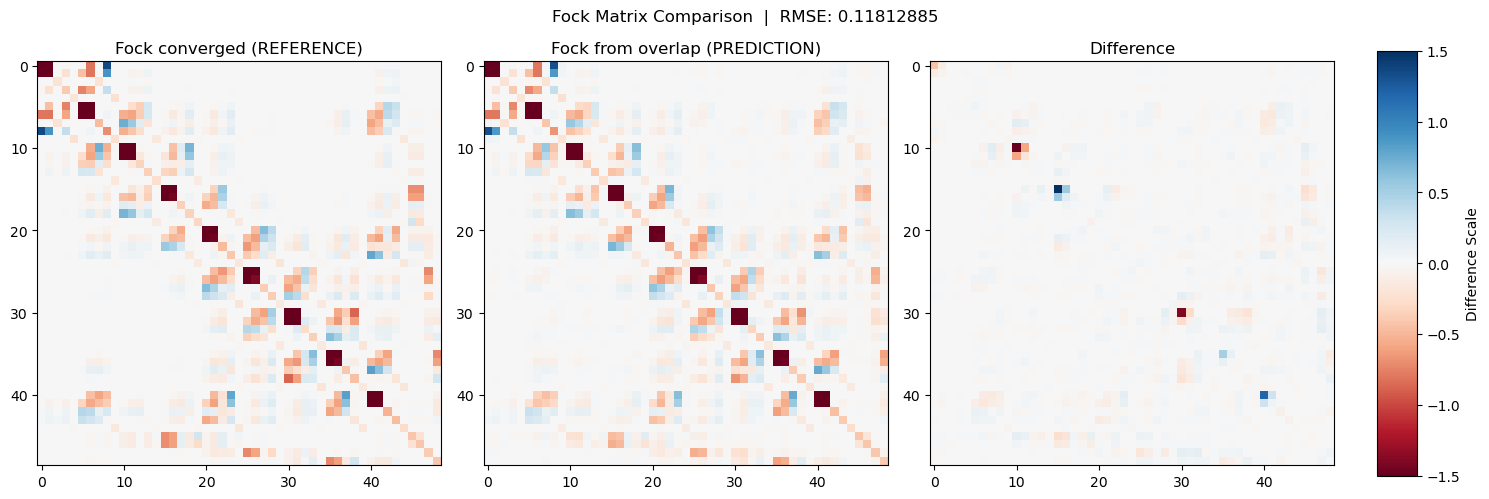

In [15]:
# let's checkout a example: 
random_test_sample = np.random.randint(0, len(X_test))
ex_test = y_test[random_test_sample]
ex_pred = test_pred[random_test_sample]

plot_fock_comparison(ex_test, ex_pred, 49, title="Fock Matrix Comparison", vmax=1.5)

# Check if convergence is faster! 

In [16]:
from scf_guess_tools import Backend, guess, calculate, load
from pyscf import scf

def sim(file, overlap, model=model, scheme="1e", use_pred=False): 
    backend = Backend.PY
    mol = load(file, backend)
    mol_native = mol.native
    mol_native.basis = "sto-3g"
    mol_native.build()

    if use_pred: 
        start_ = time.time()
        D_ = density_pred(model, overlap, mol_native.nelec[0]) # nocc per shell
        mf = scf.RKS(mol_native)
        mf.xc = "b3lypg"
        print(f"Pred time, {time.time() - start_}")
        mf.kernel(dm0=D_) 
        wf = mf
        
    else: 
        wf = calculate(mol, basis="sto-3g", method="dft", functional="b3lypg", guess=scheme, cache=False)
        wf = wf.native
    print(f"SCF cycles: {wf.cycles}")
    return {"cycles": wf.cycles, "conv": wf.converged, "summary": wf.scf_summary}

In [17]:
def benchmark_model(model, dataset=test, scheme="1e", early_stop=50, only_ref=False, only_model=False):
    reference_time, model_time = [], []
    iterations = []
    for _, overlap, file, _ in dataset: # benchmark on test data! 
        print(f"File: {file}")
        res, res_ref = None, None
        if not only_model:
            start_ = time.time()
            res_ref = sim(file, overlap, model=model, scheme=scheme, use_pred=False)
            # print(res_ref)
            end_ = time.time()
            # print(f"Reference time: {end_ - start_:.2f} seconds")
            reference_time.append(end_ - start_)

        if not only_ref:
            start_ = time.time()
            res = sim(file, overlap, model=model, use_pred=True)
            # print(res)
            end_ = time.time()
            # print(f"Guess time: {end_ - start_:.2f} seconds")
            model_time.append(end_ - start_)
        res_it = res["cycles"] if res else None
        res_ref_it = res_ref["cycles"] if res_ref else None
        iterations.append((res_it, res_ref_it))    
        if early_stop < 0: 
            break
        early_stop -= 1
    return reference_time, model_time, iterations




In [18]:
results = {"minao": None, "1e": None, "atom": None, "huckel": None, "vsap": None}
for key in results.keys():
    reference_time, model_time, iterations = benchmark_model(model, test, scheme=key, only_ref=True)
    results[key] = {"reference_time": reference_time, "model_time": model_time, "iterations": iterations}

File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_028121.xyz
converged SCF energy = -446.946703900964
SCF cycles: 11
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_131581.xyz
converged SCF energy = -446.816879401013
SCF cycles: 11
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_131100.xyz
converged SCF energy = -446.808814674099
SCF cycles: 11
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_131749.xyz
converged SCF energy = -446.832615178597
SCF cycles: 12
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_025279.xyz
converged SCF energy = -446.954407732619
SCF cycles: 12
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_024377.xyz


KeyboardInterrupt: 

In [47]:
_, model_time_model, iterations_model = benchmark_model(model, test, only_model=True)


File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_028121.xyz
Pred time, 0.06304669380187988
converged SCF energy = -446.946703900945
SCF cycles: 13
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_131581.xyz
Pred time, 0.16013383865356445
converged SCF energy = -446.816879400213
SCF cycles: 19
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_131100.xyz
Pred time, 0.11953186988830566
converged SCF energy = -446.808814673412
SCF cycles: 23
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_131749.xyz
Pred time, 0.12796998023986816
SCF not converged.
SCF energy = -382.814202549087
SCF cycles: 50
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_025279.xyz
Pred time, 0.1323564052581787
converged SCF energy = -446.954407732551
SCF cycles: 15
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_024377.xyz
Pred time, 0.13691997528076172
converged SCF energy = -446.937717046115
SCF cycles: 11
File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_025119.xyz
Pred time, 0.13054466247558594
converged SCF energy = -44

In [48]:
import uncertainties as unc
from uncertainties import unumpy
import pandas as pd

results_df = pd.DataFrame({
    "Method": ["minao"] * len(results["minao"]["iterations"]) + ["1e"] * len(results["1e"]["iterations"]) + 
              ["atom"] * len(results["atom"]["iterations"]) + ["huckel"] * len(results["huckel"]["iterations"]) + 
              ["vsap"] * len(results["vsap"]["iterations"]),
    "Iterations": [it[0] for method in results.keys() for it in results[method]["iterations"]],
    "Times": [time for method in results.keys() for time in results[method]["reference_time"]]
})
results_df_conv = results_df[results_df["Iterations"] < 50]
results_df_not_conv = results_df[results_df["Iterations"] >= 50]
not_conv_perc = results_df_not_conv["Method"].value_counts() / len(results["vsap"]["iterations"])
print(f"Not converged percentage: {not_conv_perc}")

methods = results.keys()
mean_time = unumpy.uarray([results_df_conv[results_df_conv["Method"] == method]["Times"].mean() for method in methods], [results_df_conv[results_df_conv["Method"] == method]["Times"].std() for method in methods])
mean_it = unumpy.uarray([results_df_conv[results_df_conv["Method"] == method]["Iterations"].mean() for method in methods], [results_df_conv[results_df_conv["Method"] == method]["Iterations"].std() for method in methods])
for c, method in enumerate(methods):
    print(f"{method}: {mean_time[c]:.2f} seconds, {mean_it[c]:.2f} iterations")

NameError: name 'results' is not defined

In [49]:
# results for model
model_not_conv_perc = np.sum(np.array([it[0] for it in iterations_model]) >= 50) / len(iterations_model) 
model_time_conv = np.array([time for it, time in zip(iterations_model, model_time_model) if it[0] < 50])
model_it_conv = np.array([it[0] for it in iterations_model if it[0] < 50])

print(f"Model not converged percentage: {model_not_conv_perc:.3f}")
time_ = unc.ufloat(model_time_conv.mean(), model_time_conv.std())
it_ = unc.ufloat(model_it_conv.mean(), model_it_conv.std())
print(f"Model: {time_:.2f} seconds, {it_:.2f} iterations")
len(test)

Model not converged percentage: 0.154
Model: 5.31+/-1.96 seconds, 17.55+/-5.59 iterations


102

Not converged reference: 2
Not converged model: 0


TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

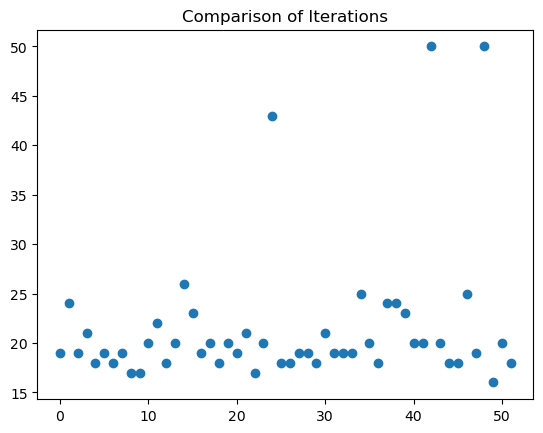

In [137]:
import uncertainties as unc
def analyze_res(iterations, reference_time, model_time):
    reference_it = [it[0] for it in iterations]
    model_it = [it[1] for it in iterations]
    reference_time_c = [time for time in reference_time]
    model_time_c = [time for time in model_time]
    plt.scatter(np.arange(len(reference_it)), reference_it, label="Reference")
    plt.scatter(np.arange(len(reference_it)), model_it, label="Model")
    plt.title("Comparison of Iterations")
    print(f"Not converged reference: {len([it for it in reference_it if it == 50])}")
    print(f"Not converged model: {len([it for it in model_it if it == 50])}")

    converged_ind = np.where(np.array(reference_it) != 50)[0]
    # converged_ind_model = np.where(np.array(model_it) != 50)[0]
    converged_ind_model = converged_ind # use the same indices for fair comparison
    reference_it = np.array(reference_it)[converged_ind]
    model_it = np.array(model_it)[converged_ind_model]
    reference_time_c = np.array(reference_time_c)[converged_ind]
    model_time_c = np.array(model_time_c)[converged_ind_model]


    it = unc.ufloat(np.mean(reference_it), np.std(reference_it))
    it_model = unc.ufloat(np.mean(model_it), np.std(model_it))
    print(f"Reference iterations: {it}")
    print(f"Model iterations: {it_model}")
    time_ref = unc.ufloat(np.mean(reference_time_c), np.std(reference_time_c))
    time_model = unc.ufloat(np.mean(model_time_c), np.std(model_time_c))
    print(f"Reference time: {time_ref}")
    print(f"Model time: {time_model}")
    print(f"Speedup: {time_ref / time_model:.2f}x")

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.boxplot([reference_time_c, model_time_c], labels=["Reference", "Model"], patch_artist=True)
    ax.set_title("Comparison of Computation Times")
    ax.set_ylabel("Time (seconds)")
    ax.set_xlabel("Method")
    plt.show()
analyze_res(iterations_model, [], model_time_model)



In [34]:
sample_file = used_files[0]
mol = load(sample_file, Backend.PY)
nr_elec = mol.native.nelec[0]
ref_density = reference_densities[0]
print(nr_elec)
guess_density = density_pred(model, overlaps[0], nr_elec)
comp_trace(overlaps[0], ref_density, guess_density)

32
Trace: 32.00000310499718
Trace: 32.00000000000001


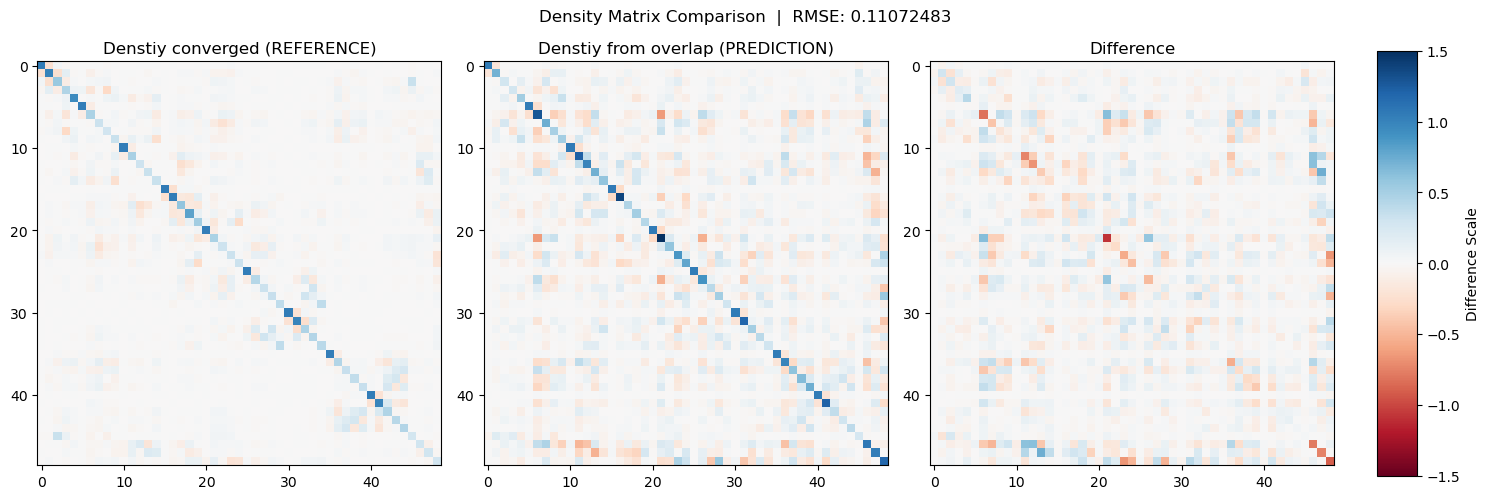

In [121]:
plot_fock_comparison(ref_density, guess_density, 49, matrix_metric="Denstiy", title="Density Matrix Comparison", vmax=1.5)

Ok - reference Fock --> Density mit Ref Density vergleichen - die sollten exakt gleich sein

In [83]:
def density_from_fock(fock, overlap, nocc): 
    _, C = eigh(fock, overlap)
    C_occ = C[:, :nocc]
    density = C_occ @ C_occ.T
    return density

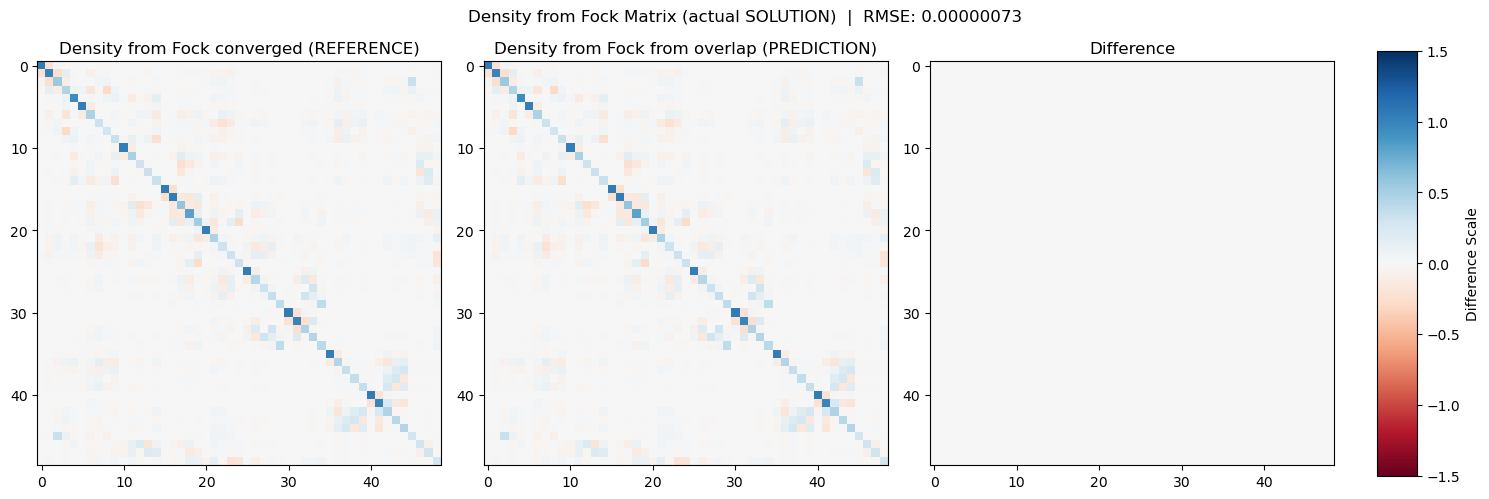

In [84]:
ref_fock = focks[0]
density_from_fock = density_from_fock(ref_fock, overlaps[0], nr_elec)
plot_fock_comparison(ref_density, density_from_fock, 49, matrix_metric="Density from Fock", title="Density from Fock Matrix (actual SOLUTION)", vmax=1.5)

Ok es funktioniert also, wenn die Fock-Matrix wohl sehr ähnlich ist! Noch ein Sanity check ob auch die iterationen gegen 1 gehen: 

converged SCF energy = -446.946703900964
Took: 11 cycles: 3.68 seconds
Loaded mol from ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_028121.xyz
converged SCF energy = -446.946703900964
Sum of squares density new calc: 26.8880 - nr elec: 32.0
Sum of squares density scf: 107.5519 - nr elec: 63.99999999999996


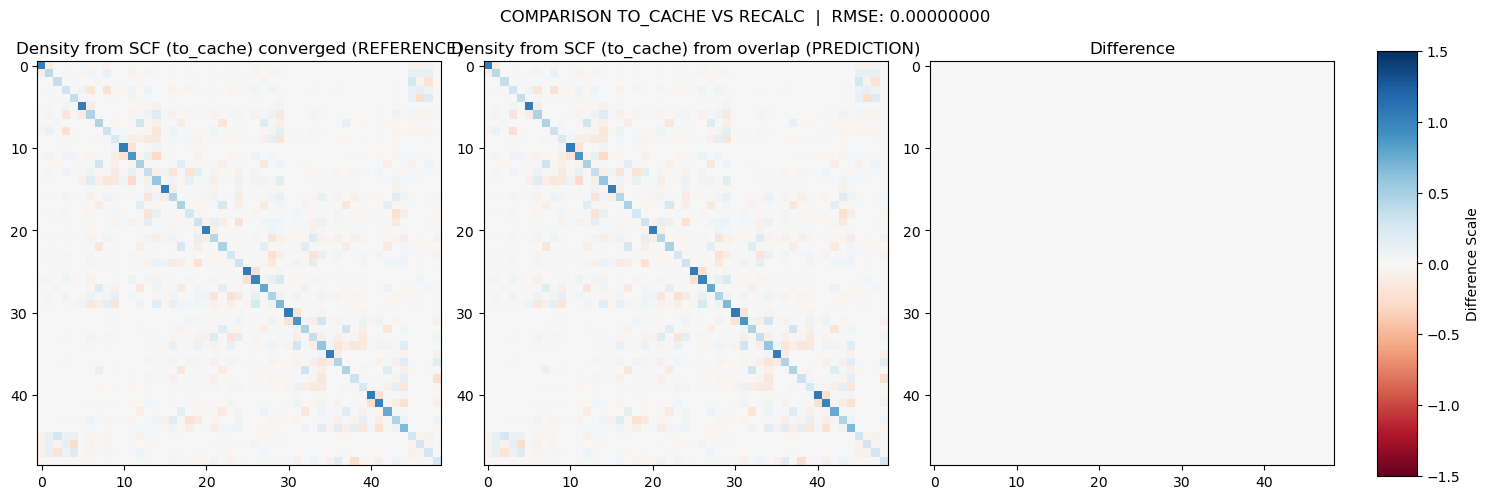

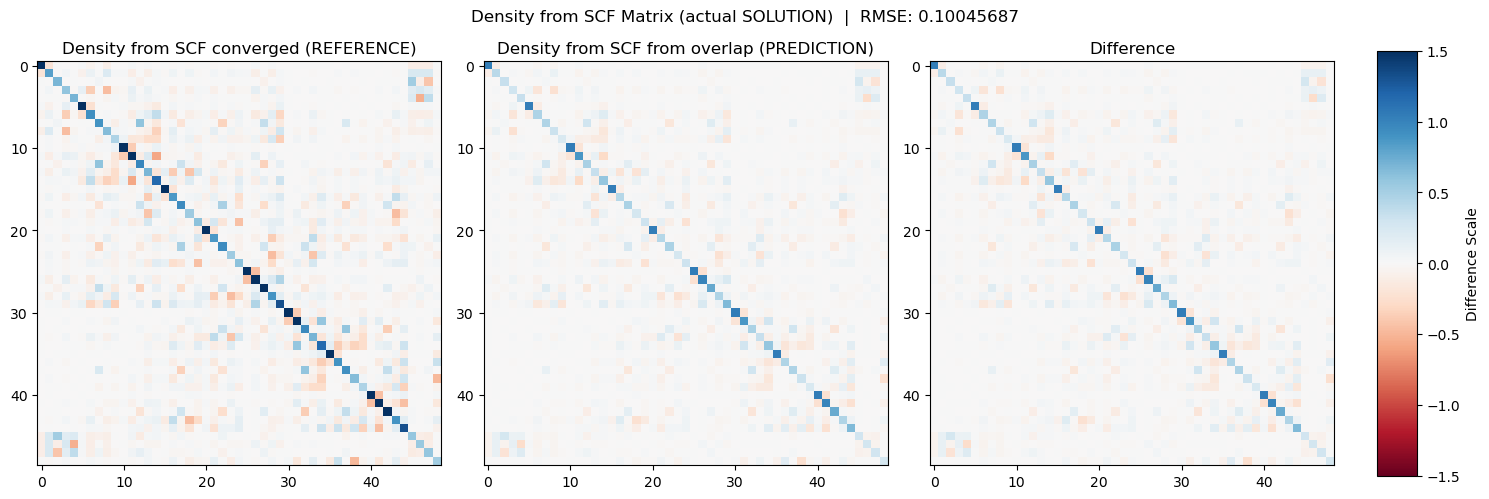

In [97]:
start_ = time.time()
file = test[0][2]
mol = load(file, Backend.PY).native
mol.basis = "sto-3g"
mol.build()

mf = scf.RKS(mol)
mf.xc = "b3lypg"
mf.kernel()
print(f"Took: {mf.cycles} cycles: {time.time() - start_:.2f} seconds")
density_matrix_scf = mf.make_rdm1()
overlap = mol.intor('int1e_ovlp')


ret = density_fock_overlap(filepath = file,
                         filename = os.path.basename(file).split(".")[0],
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = "../../datasets/QM9/out/c5h4n2o2-sto-3g-b3lyp")

ret_new = density_fock_overlap(filepath = file,
                         filename = os.path.basename(file).split(".")[0],
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = False)
reference_density = ret[0].numpy
ref_overlap = ret_new[2].numpy
density_matrix_new_calc = ret_new[0].numpy


sum_of_squares_density_new_calc = np.sum(density_matrix_new_calc**2)
sum_of_squares_density_scf = np.sum(density_matrix_scf**2)
nr_elec_scf = np.trace(density_matrix_scf @ overlap)
nr_elec_new_calc = np.trace(density_matrix_new_calc @ ref_overlap)
print(f"Sum of squares density new calc: {sum_of_squares_density_new_calc:.4f} - nr elec: {nr_elec_new_calc}")
print(f"Sum of squares density scf: {sum_of_squares_density_scf:.4f} - nr elec: {nr_elec_scf}")
# plot_fock_comparison(density_matrix_new_calc, reference_density, 49, matrix_metric="Density from SCF (to_cache)", title="COMPARISON TO_CACHE VS RECALC", vmax=1.5)
plot_fock_comparison(density_matrix_scf, reference_density, 49, matrix_metric="Density from SCF", title="COMPARISON TO_CACHE VS RECALC", vmax=1.5)

Wo ist der unterschied zwischen meinem to_cache wrapper und default pyscf?

In [101]:
file = test[0][2]
print(f"File: {file}")
to_cache_ret = density_fock_overlap(filepath = file,
                         filename = os.path.basename(file).split(".")[0],
                         method = "dft",
                         basis = "sto-3g",
                         functional = "b3lypg",
                         guess = "minao",
                         backend = "pyscf",
                         cache = False)
density_matrix_new_calc = to_cache_ret[0].numpy
overlap = to_cache_ret[2].numpy
print(f"Trace: {np.trace(density_matrix_new_calc @ overlap):.4f}")

File: ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_028121.xyz
Loaded mol from ../../datasets/QM9/xyz_c5h4n2o2/dsgdb9nsd_028121.xyz
converged SCF energy = -446.946703900965
Trace: 32.0000


# Minao vs. Ridge density

In [33]:
test_files = [x[2] for x in test]
overlaps = [x[1] for x in test]
ref_densities = [x[3] for x in test]
from scf_guess_tools import guess, Backend

In [35]:
mols = [load(file, Backend.PY) for file in test_files]

In [45]:

minao_guesses = [guess(mol, basis="sto-3g", method="dft", functional="b3lypg", scheme="minao", cache=False) for mol in mols]
vsap_guesses = [guess(mol, basis="sto-3g", method="dft", functional="b3lypg", scheme="vsap", cache=False) for mol in mols]
minao_densities = [x.density().numpy for x in minao_guesses]
vsap_densities = [x.density().numpy for x in vsap_guesses]

In [47]:
minao_fock = [x.fock().numpy for x in minao_guesses]
vsap_fock = [x.fock().numpy for x in vsap_guesses]

In [46]:
ridge_predict = [model.predict(flatten_triang(overlap).reshape(1, -1)) for overlap in overlaps]
shape_ = overlaps[0].shape[0]
ridge_fock = [unflatten_triang(fock, shape_) for fock in ridge_predict]

In [104]:
ridge_densities = [0.5 * density_pred(model, overlap, mol.native.nelec[0]) for mol, overlap in zip(mols, overlaps)]

In [105]:
reference_densities = [x[3] for x in test]
reference_focks = [x[0] for x in test]
reference_densities[0].shape

(49, 49)

In [108]:
def normalize_data(minao_data, ridge_data, vsap_data, ref_data, overlaps):
    #! makes only sense if we project to orthonormal basis - Mulliken Population
    minao_mean_trace = np.mean([np.trace(density @ overlap) for overlap, density in zip(overlaps, minao_data)])
    vsap_mean_trace = np.mean([np.trace(density @ overlap) for overlap, density in zip(overlaps, vsap_data)])
    ridge_mean_trace = np.mean([np.trace(density @ overlap) for overlap, density in zip(overlaps, ridge_data)])
    ref_mean_trace = np.mean([np.trace(density @ overlap) for overlap, density in zip(overlaps, ref_data)])
    print("Only alpha-electrons")
    print(f"MinAO mean trace: {minao_mean_trace:.4f}")
    print(f"VSAP mean trace: {vsap_mean_trace:.4f}")
    print(f"Ridge mean trace: {ridge_mean_trace:.4f}")
    print(f"Reference mean trace: {ref_mean_trace:.4f}")
    
    minao_data = [density / np.linalg.norm(density) for density in minao_data]
    ridge_data = [density / np.linalg.norm(density) for density in ridge_data]
    vsap_data = [density / np.linalg.norm(density) for density in vsap_data]
    ref_data = [density / np.linalg.norm(density) for density in ref_data]


    # build difference! 
    delta_minao = [
        density - ref_density for density, ref_density in zip(minao_data, ref_data)
    ]
    delta_ridge = [
        density - ref_density for density, ref_density in zip(ridge_data, ref_data)
    ]
    delta_vsap = [
        density - ref_density for density, ref_density in zip(vsap_data, ref_data)
    ]


    delta_minao = np.mean(delta_minao, axis=0)
    delta_ridge = np.mean(delta_ridge, axis=0)
    delta_vsap = np.mean(delta_vsap, axis=0)

    # # renormalize to 1
    # delta_minao /= np.linalg.norm(delta_minao)
    # delta_ridge /= np.linalg.norm(delta_ridge)
    # delta_vsap /= np.linalg.norm(delta_vsap)
    return delta_minao, delta_ridge, delta_vsap


Only alpha-electrons
MinAO mean trace: 31.7660
VSAP mean trace: 32.0000
Ridge mean trace: 32.0000
Reference mean trace: 32.0000
Only alpha-electrons
MinAO mean trace: -184.7376
VSAP mean trace: -169.9173
Ridge mean trace: -174.4380
Reference mean trace: -178.9809


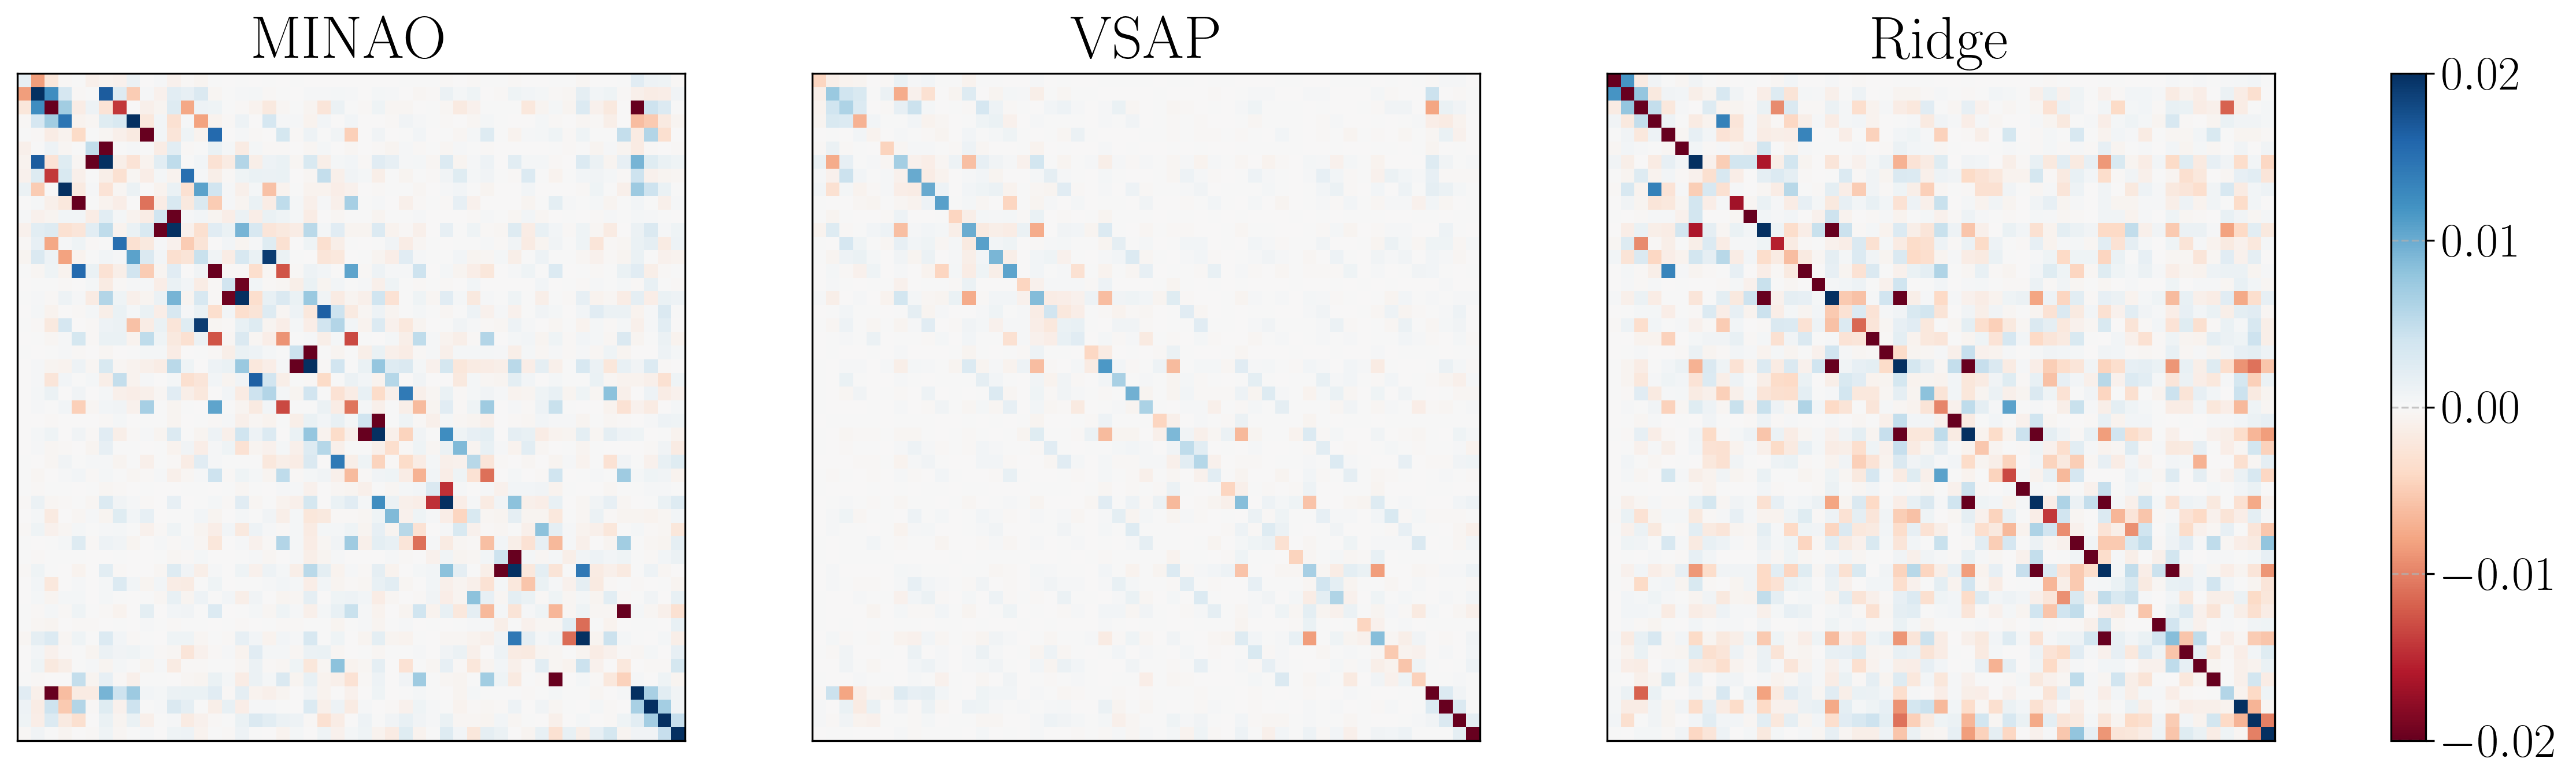

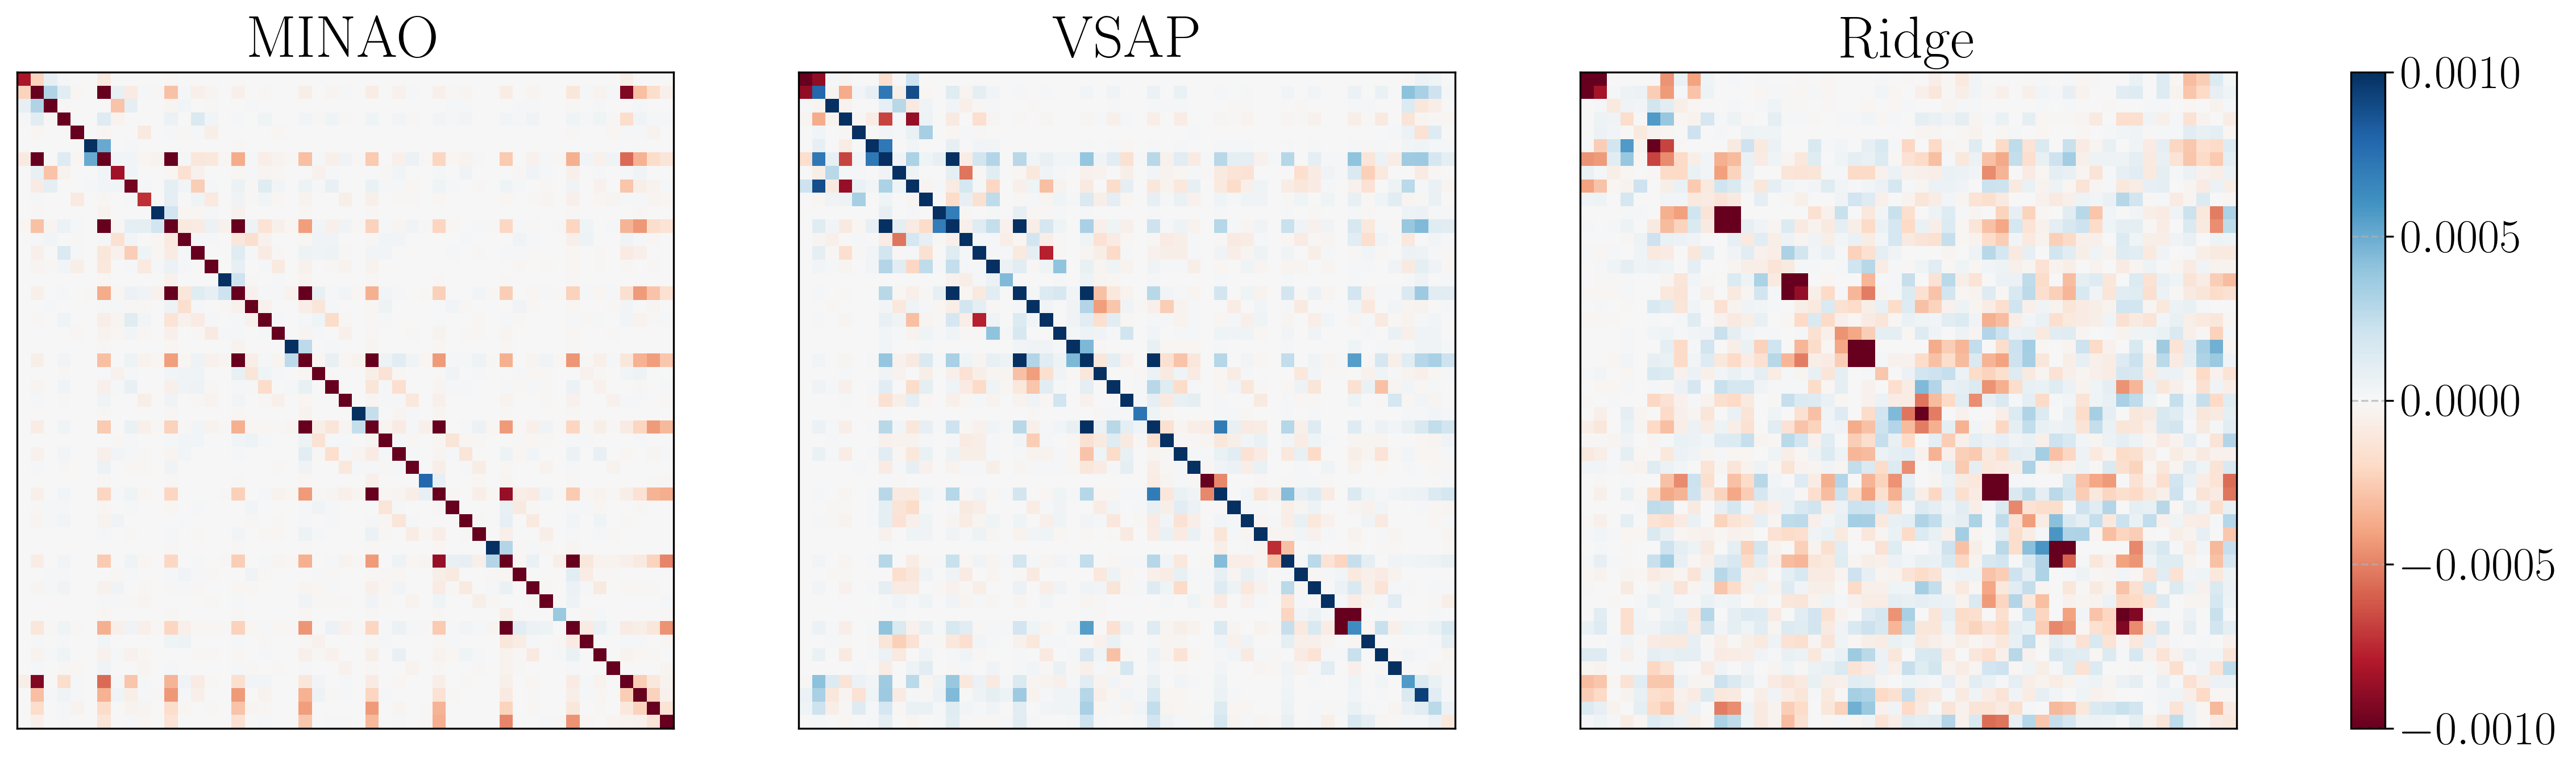

In [109]:
def plot_3_schemes(delta_minao_mean, delta_ridge_mean, delta_vsap_mean, filename="density_error_comparison", clipval=0.1):
    from matplotlib.colors import SymLogNorm
    plotting_script_base = "../../latex/scripts"
    sys.path.append(plotting_script_base)
    from plt_config import use_latex, TU_GREY, TU_RED
    use_latex()

    norm = SymLogNorm(linthresh=1e-2, linscale=0.7, vmin=-clipval, vmax=clipval, base=10)
    # norm=None
    fig, ax = plt.subplots(1, 4, figsize=(18, 5), width_ratios=[1, 1, 1, 0.05])

    # Plot 1: MINAO
    im0 = ax[0].imshow(delta_minao_mean, cmap='RdBu', vmin=-clipval, vmax=clipval)
    ax[0].set_title("MINAO", fontsize=25)
    # fig.colorbar(im0, cax=ax[1])

    # Plot 2: VSAP
    im1 = ax[1].imshow(delta_vsap_mean, cmap='RdBu', vmin=-clipval, vmax=clipval)
    ax[1].set_title("VSAP", fontsize=25)
    # fig.colorbar(im1, cax=ax[3])

    # Plot 3: Ridge
    im2 = ax[2].imshow(delta_ridge_mean, cmap='RdBu', vmin=-clipval, vmax=clipval)
    ax[2].set_title("Ridge", fontsize=25)
    cbar = fig.colorbar(im2, cax=ax[3])
    cbar.ax.tick_params(labelsize=20)

    for i in range(3):
        ax[i].set_xticks([])
        ax[i].set_yticks([])


    plt.savefig(f"../../latex/fig/c5h4n2o2/{filename}.pdf", bbox_inches='tight')
plot_3_schemes(*normalize_data(minao_densities, ridge_densities, vsap_densities, reference_densities, overlaps), filename="density_error_comparison", clipval=0.02)
plot_3_schemes(*normalize_data(minao_fock, ridge_fock, vsap_fock, reference_focks, overlaps), filename="fock_error_comparison", clipval=0.001)

# Inference Time Benchmark

In [37]:
import uncertainties as unc
# inference of model 
time_ = []
# Ridge is Benchmark
for mol, overlap in zip(mols, overlaps):
    start_ = time.time()
    density_pred(model, overlap, mol.native.nelec[0])
    time_.append(time.time() - start_)
ref_time = unc.ufloat(np.mean(time_), np.std(time_))
print(f"Ridge time: {ref_time:.2f} seconds")
ridge_time = ref_time

scheme_times = []
# Comparison
for guessing_scheme in ["minao", "1e", "atom", "huckel", "vsap"]:
    print(f"Guessing scheme: {guessing_scheme}")
    time_ = []
    for mol in mols: 
        start_ = time.time()
        guess(mol, basis="sto-3g", method="dft", functional="b3lypg", scheme=guessing_scheme, cache=False)
        time_.append(time.time() - start_)
    time_ = unc.ufloat(np.mean(time_), np.std(time_))
    scheme_times.append(time_)
    print(f"Time: {time_:.2f} seconds - {time_ / ref_time:.2f}x speedup")

Ridge time: 0.15+/-0.05 seconds
Guessing scheme: minao
Time: 0.08+/-0.03 seconds - 0.57+/-0.29x speedup
Guessing scheme: 1e
Time: 0.02+/-0.01 seconds - 0.10+/-0.08x speedup
Guessing scheme: atom
Time: 0.14+/-0.11 seconds - 0.96+/-0.78x speedup
Guessing scheme: huckel
Time: 0.17+/-0.06 seconds - 1.12+/-0.52x speedup
Guessing scheme: vsap
Time: 0.73+/-0.25 seconds - 4.92+/-2.26x speedup


For better comparability Minao as reference: 

In [ ]:
minao_time = scheme_times[0]
for name, scheme in zip(["ridge", "1e", "atom", "huckel", "vsap"], [ridge_time, *scheme_times[1:]]): 
    print(f"Factor: {name}: {scheme / minao_time:.2f}x")


Speedup: ridge: 1.75+/-0.89x
Speedup: 1e: 0.18+/-0.15x
Speedup: atom: 1.68+/-1.43x
Speedup: huckel: 1.96+/-1.05x
Speedup: vsap: 8.59+/-4.55x
